In [1]:
import sys
sys.path.insert(1, '/home/patryk_mscwrona/repos') # inserting a library's directory

from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import matplotlib.pyplot as plt

from river import optim
from river import linear_model
from river import forest
from river import tree
from river import ensemble
from river import preprocessing
from river import metrics
from river import dummy
from river import utils
from river import drift
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
          'figure.figsize': (18, 18),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

from Fleuve.master import stream_miner_master
from Fleuve.master import evaluator_master
from Fleuve.master import predictor_master
from Fleuve.master import drift_detector_master

# from Fleuve.shared import stream_miner_handler
# from Fleuve.shared import evaluator_handler
# from Fleuve.shared import predictor_handler
# from Fleuve.shared import drift_detector_handler

# initialize credit card input
from Fleuve.evaluation.initialize_scripts.initialize_credit_card import InitializeCC
from Fleuve.evaluation.initialize_scripts.initialize_agrawal import InitializeA
from Fleuve.evaluation.initialize_scripts.initialize_agrawal import InitializeA_CD
from Fleuve.evaluation.initialize_scripts.initialize_hyperplane import InitializeH
from Fleuve.evaluation.initialize_scripts.initialize_credit_card_delayed import InitializeCCD
from Fleuve.evaluation.initialize_scripts.initialize_virtual_drift import InitializeVD
from Fleuve.evaluation.initialize_scripts.initialize_benchmark import InitializeBENCHMARK

# StreamMiner

In [2]:
init = InitializeBENCHMARK()
spark, input_schema, sc, sdf = init.spark, init.input_schema, init.sc, init.sdf

23/06/21 14:43:35 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [7]:
sc = SparkContext.getOrCreate()
sc.addPyFile("/home/patryk_patrykwrona/repos/Fleuve/worker/evaluator.py")
sc.addPyFile("/home/patryk_patrykwrona/repos/Fleuve/shared/evaluator_handler.py")
sc.addPyFile("/home/patryk_patrykwrona/repos/Fleuve/worker/drift_detector.py")
sc.addPyFile("/home/patryk_patrykwrona/repos/Fleuve/shared/drift_detector_handler.py")
sc.addPyFile("/home/patryk_patrykwrona/repos/Fleuve/worker/stream_miner.py")
sc.addPyFile("/home/patryk_patrykwrona/repos/Fleuve/shared/stream_miner_handler.py")
sc.addPyFile("/home/patryk_patrykwrona/repos/Fleuve/worker/predictor.py")
sc.addPyFile("/home/patryk_patrykwrona/repos/Fleuve/shared/predictor_handler.py")
sc.addPyFile("/home/patryk_patrykwrona/repos/Fleuve/worker/caching.py")

In [8]:
#SET TASK
task = {"cluster-9e14-w-0": {"models": [dummy.NoChangeClassifier(), 
                                        tree.ExtremelyFastDecisionTreeClassifier(max_depth = 20), 
                                        forest.ARFClassifier(seed = 44, n_models = 5, max_depth = 20), 
                                        tree.HoeffdingTreeClassifier(max_depth = 20)]}, 
        "cluster-9e14-w-1" : {"models": [dummy.NoChangeClassifier(), 
                                        tree.ExtremelyFastDecisionTreeClassifier(max_depth = 20), 
                                        forest.ARFClassifier(seed = 44, n_models = 5, max_depth = 20), 
                                        tree.HoeffdingTreeClassifier(max_depth = 20)]}, 
        'workers': ["cluster-9e14-w-0", "cluster-9e14-w-1"],
       'eval_metrics': [metrics.Accuracy(), 
                        metrics.BalancedAccuracy(), 
                        metrics.F1(), 
                        metrics.CohenKappa()]}

In [9]:
# data_cols = [field.name for field in input_schema.fields][:-1]

data_cols = ['V' + str(i) for i in range(1,29)]
data_cols.append('Amount') 

sm = stream_miner_master.StreamMinerMaster(data_cols, task)

In [10]:
output_schema = sm.output_schema
output_schema

StructType([StructField('training_time', FloatType(), False), StructField('n', IntegerType(), False), StructField('hostname', StringType(), False), StructField('hash', StringType(), False), StructField('model_name', StringType(), False), StructField('prediction', DoubleType(), False), StructField('Accuracy', FloatType(), False), StructField('BalancedAccuracy', FloatType(), False), StructField('F1', FloatType(), False), StructField('CohenKappa', FloatType(), False), StructField('model_name_2', StringType(), False), StructField('prediction_2', DoubleType(), False), StructField('Accuracy_2', FloatType(), False), StructField('BalancedAccuracy_2', FloatType(), False), StructField('F1_2', FloatType(), False), StructField('CohenKappa_2', FloatType(), False), StructField('model_name_3', StringType(), False), StructField('prediction_3', DoubleType(), False), StructField('Accuracy_3', FloatType(), False), StructField('BalancedAccuracy_3', FloatType(), False), StructField('F1_3', FloatType(), Fal

In [6]:
sdf = sm.transform(sdf)

23/06/18 00:48:34 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
sdf.isStreaming

False

In [9]:
sdf = sm.transform(sdf)

In [14]:
# sdf.select(*sm.result_cols) \
#             .write \
#             .format("csv")\
#             .option("path", "user/hdfs/evaluation/sm/benchmark/try" + "") \
#             .start()

AttributeError: 'DataFrameWriter' object has no attribute 'start'

In [ ]:

for i in range(100):
    sdf.select(*sm.result_cols).write.options(header='False', delimiter=',') \
     .csv("hdfs://cluster-9e14-m/user/hdfs/evaluation/sm/benchmark/case" + str(i))

23/06/18 00:57:05 WARN TaskSetManager: Lost task 0.0 in stage 1.0 (TID 2) (cluster-9e14-w-1.us-central1-a.c.teak-territory-381818.internal executor 3): org.apache.spark.SparkException: Task failed while writing rows.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.taskFailedWhileWritingRowsError(QueryExecutionErrors.scala:641)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:369)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$21(FileFormatWriter.scala:258)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)

23/06/18 01:13:46 WARN TaskSetManager: Lost task 0.0 in stage 3.0 (TID 8) (cluster-9e14-w-1.us-central1-a.c.teak-territory-381818.internal executor 2): org.apache.spark.SparkException: Task failed while writing rows.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.taskFailedWhileWritingRowsError(QueryExecutionErrors.scala:641)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:369)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$21(FileFormatWriter.scala:258)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)

23/06/18 01:32:12 WARN TaskSetManager: Lost task 1.0 in stage 5.0 (TID 15) (cluster-9e14-w-1.us-central1-a.c.teak-territory-381818.internal executor 2): org.apache.spark.SparkException: Task failed while writing rows.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.taskFailedWhileWritingRowsError(QueryExecutionErrors.scala:641)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:369)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$21(FileFormatWriter.scala:258)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128

# Evaluator

In [13]:
init = InitializeBENCHMARK()
spark, input_schema, sc, sdf = init.spark, init.input_schema, init.sc, init.sdf

23/06/18 12:20:01 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/worker/evaluator.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/18 12:20:01 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/master/evaluator_handler.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/18 12:20:01 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/worker/drift_detector.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/18 12:20:01 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/master/drift_detector_handler.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/18 12:20:01 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/worker/stream_miner.py has been added already. Overwriting of added paths is not supported in the current 

In [14]:
#SET TASK
task = {"cluster-9e14-w-0": {"pretrained_models": ['NoChangeClassifier_cluster-9e14-w-0_271321.pkl', 
                                        'ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-0_271321.pkl',
                                       'ARFClassifier_cluster-9e14-w-0_271321.pkl',
                                       'HoeffdingTreeClassifier_cluster-9e14-w-0_271321.pkl']}, 
        "cluster-9e14-w-1" : {"pretrained_models": ['NoChangeClassifier_cluster-9e14-w-0_271321.pkl', 
                                        'ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-0_271321.pkl',
                                       'ARFClassifier_cluster-9e14-w-0_271321.pkl',
                                       'HoeffdingTreeClassifier_cluster-9e14-w-0_271321.pkl']}, 
        'workers': ["cluster-9e14-w-0", "cluster-9e14-w-1"],
       'eval_metrics': [metrics.Accuracy(), 
                        metrics.BalancedAccuracy(), 
                        metrics.F1(), 
                        metrics.CohenKappa()]}

In [26]:
# data_cols = [field.name for field in input_schema.fields][:-1]

data_cols = ['V' + str(i) for i in range(1,29)]
data_cols.append('Amount') 

em = evaluator_master.EvaluatorMaster(data_cols, task)

In [17]:
sdf = em.transform(sdf)

In [ ]:

for i in range(100):
    sdf.select(*em.result_cols).write.options(header='False', delimiter=',') \
     .csv("hdfs://cluster-9e14-m/user/hdfs/evaluation/em/benchmark/case" + str(i))

# Predictor

In [19]:
init = InitializeBENCHMARK()
spark, input_schema, sc, sdf = init.spark, init.input_schema, init.sc, init.sdf

23/06/18 15:27:06 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/worker/evaluator.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/18 15:27:06 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/master/evaluator_handler.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/18 15:27:06 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/worker/drift_detector.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/18 15:27:06 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/master/drift_detector_handler.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/18 15:27:06 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/worker/stream_miner.py has been added already. Overwriting of added paths is not supported in the current 

In [44]:
#SET TASK
task = {"cluster-9e14-w-0": {"pretrained_models": ['NoChangeClassifier_cluster-9e14-w-0_271321.pkl', 
                                        'ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-0_271321.pkl',
                                       'ARFClassifier_cluster-9e14-w-0_271321.pkl',
                                       'HoeffdingTreeClassifier_cluster-9e14-w-0_271321.pkl']}, 
        "cluster-9e14-w-1" : {"pretrained_models": ['NoChangeClassifier_cluster-9e14-w-0_271321.pkl', 
                                        'ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-0_271321.pkl',
                                       'ARFClassifier_cluster-9e14-w-0_271321.pkl',
                                       'HoeffdingTreeClassifier_cluster-9e14-w-0_271321.pkl']}, 
        'workers': ["cluster-9e14-w-0", "cluster-9e14-w-1"]}

In [21]:
# data_cols = [field.name for field in input_schema.fields][:-1]

data_cols = ['V' + str(i) for i in range(1,29)]
data_cols.append('Amount') 

pm = predictor_master.PredictorMaster(data_cols, task)

In [22]:
sdf = pm.transform(sdf)

In [ ]:

for i in range(100):
    sdf.select(*pm.result_cols).write.options(header='False', delimiter=',') \
     .csv("hdfs://cluster-9e14-m/user/hdfs/evaluation/pm/benchmark/case" + str(i))

# Analysis of benchmark data

### StreamMiner

In [11]:
# output_schema = sm.output_schema

df = spark.read.format("csv").options(header='false').schema(output_schema). \
load("hdfs://cluster-9e14-m/user/hdfs/evaluation/sm/benchmark/case0")

In [13]:
pdf = df.toPandas()

23/06/21 15:05:18 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [14]:
pdf.head()

,training_time,n,hostname,hash,model_name,prediction,Accuracy,BalancedAccuracy,F1,CohenKappa,...,Accuracy_3,BalancedAccuracy_3,F1_3,CohenKappa_3,model_name_4,prediction_4,Accuracy_4,BalancedAccuracy_4,F1_4,CohenKappa_4
0,0.024398,1,cluster-9e14-w-1,jowtcouc5z8l0hka,NoChangeClassifier,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,HoeffdingTreeClassifier,0.0,0.000000,0.000000,0.0,0.0
1,0.025639,2,cluster-9e14-w-1,jowtcouc5z8l0hka,NoChangeClassifier,0.0,0.500000,0.250000,0.0,0.0,...,0.500000,0.250000,0.0,0.0,HoeffdingTreeClassifier,0.0,0.500000,0.250000,0.0,0.0
2,0.026908,3,cluster-9e14-w-1,jowtcouc5z8l0hka,NoChangeClassifier,0.0,0.666667,0.333333,0.0,0.0,...,0.666667,0.333333,0.0,0.0,HoeffdingTreeClassifier,0.0,0.666667,0.333333,0.0,0.0
3,0.030030,4,cluster-9e14-w-1,jowtcouc5z8l0hka,NoChangeClassifier,0.0,0.750000,0.375000,0.0,0.0,...,0.750000,0.375000,0.0,0.0,HoeffdingTreeClassifier,0.0,0.750000,0.375000,0.0,0.0
4,0.031251,5,cluster-9e14-w-1,jowtcouc5z8l0hka,NoChangeClassifier,0.0,0.800000,0.400000,0.0,0.0,...,0.800000,0.400000,0.0,0.0,HoeffdingTreeClassifier,0.0,0.800000,0.400000,0.0,0.0


In [20]:
sm_zeits = []
sm_ns = []
for i in range(100):
    df = spark.read.format("csv").options(header='false').schema(output_schema). \
        load("hdfs://cluster-9e14-m/user/hdfs/evaluation/sm/benchmark/case" + str(i))
    pdf = df.toPandas()
    zeit = pdf.groupby(["hostname", "hash"])["training_time"].max().sum()
    n = pdf.groupby(["hostname", "hash"])["n"].max().sum()
    
    print(" ")
    print("FILE " + str(i) )
    print("Training time: " + str(zeit) )
    if n != 284807:
        print("Observations (not 284807): " + str(n))
    sm_zeits.append(zeit)
    sm_ns.append(n)
    

 
FILE 0
Training time: 812.63574


 
FILE 1
Training time: 1271.4818
Observations (not 284807): 431301


 
FILE 2
Training time: 1201.3125
Observations (not 284807): 431301


 
FILE 3
Training time: 805.1395


 
FILE 4
Training time: 1261.2172
Observations (not 284807): 431301


 
FILE 5
Training time: 1197.8752
Observations (not 284807): 431301


 
FILE 6
Training time: 799.15393


 
FILE 7
Training time: 1689.7822
Observations (not 284807): 569614


 
FILE 8
Training time: 2610.6416
Observations (not 284807): 854421


 
FILE 9
Training time: 2144.2585
Observations (not 284807): 699746


 
FILE 10
Training time: 634.13354


 
FILE 11
Training time: 804.7594


 
FILE 12
Training time: 1263.8629
Observations (not 284807): 431301


 
FILE 13
Training time: 1202.5292
Observations (not 284807): 431301


 
FILE 14
Training time: 800.44824


 
FILE 15
Training time: 1256.862
Observations (not 284807): 431301


 
FILE 16
Training time: 2133.0112
Observations (not 284807): 716108


 
FILE 17
Training time: 2142.1033
Observations (not 284807): 716108


 
FILE 18
Training time: 447.88278


 
FILE 19
Training time: 703.835
Observations (not 284807): 431301


 
FILE 20
Training time: 707.30444
Observations (not 284807): 431301


 
FILE 21
Training time: 449.04706


 
FILE 22
Training time: 983.51733
Observations (not 284807): 569614


 
FILE 23
Training time: 1529.813
Observations (not 284807): 854421


 
FILE 24
Training time: 1276.7728
Observations (not 284807): 724289


 
FILE 25
Training time: 790.8174


 
FILE 26
Training time: 1255.1111
Observations (not 284807): 431301


 
FILE 27
Training time: 2130.7651
Observations (not 284807): 716108


 
FILE 28
Training time: 1700.8269
Observations (not 284807): 569614


 
FILE 29
Training time: 750.32166


 
FILE 30
Training time: 452.21634


 
FILE 31
Training time: 710.0735
Observations (not 284807): 431301


 
FILE 32
Training time: 1224.3895
Observations (not 284807): 716108


 
FILE 33
Training time: 1254.4331
Observations (not 284807): 716108


 
FILE 34
Training time: 449.76138


 
FILE 35
Training time: 708.1815
Observations (not 284807): 431301


 
FILE 36
Training time: 712.0828
Observations (not 284807): 431301


 
FILE 37
Training time: 807.5637


 
FILE 38
Training time: 1716.0225
Observations (not 284807): 569614


 
FILE 39
Training time: 812.93115


 
FILE 40
Training time: 1713.6948
Observations (not 284807): 569614


 
FILE 41
Training time: 808.93066


 
FILE 42
Training time: 1703.3434
Observations (not 284807): 569614


 
FILE 43
Training time: 2632.3413
Observations (not 284807): 854421


 
FILE 44
Training time: 2170.0046
Observations (not 284807): 724289


 
FILE 45
Training time: 813.4511


 
FILE 46
Training time: 1281.2565
Observations (not 284807): 431301


 
FILE 47
Training time: 1211.5566
Observations (not 284807): 431301


 
FILE 48
Training time: 803.45984


 
FILE 49
Training time: 1252.9379
Observations (not 284807): 431301


 
FILE 50
Training time: 2145.2683
Observations (not 284807): 716108


 
FILE 51
Training time: 2143.8691
Observations (not 284807): 716108


 
FILE 52
Training time: 815.52747


 
FILE 53
Training time: 1285.8898
Observations (not 284807): 431301


 
FILE 54
Training time: 2182.709
Observations (not 284807): 716108


 
FILE 55
Training time: 2195.6812
Observations (not 284807): 716108


 
FILE 56
Training time: 451.45154


 
FILE 57
Training time: 981.27106
Observations (not 284807): 569614


 
FILE 58
Training time: 1520.6868
Observations (not 284807): 854421


 
FILE 59
Training time: 1259.6388
Observations (not 284807): 699746


 
FILE 60
Training time: 450.78897


 
FILE 61
Training time: 454.7686


 
FILE 62
Training time: 744.21497
Observations (not 284807): 431301


 
FILE 63
Training time: 1270.9664
Observations (not 284807): 716108


 
FILE 64
Training time: 1280.7378
Observations (not 284807): 716108


 
FILE 65
Training time: 453.1952


 
FILE 66
Training time: 983.7839
Observations (not 284807): 569614


 
FILE 67
Training time: 453.87326


 
FILE 68
Training time: 980.46985
Observations (not 284807): 569614


 
FILE 69
Training time: 452.49152


 
FILE 70
Training time: 991.9148
Observations (not 284807): 569614


 
FILE 71
Training time: 1549.3997
Observations (not 284807): 854421


 
FILE 72
Training time: 1283.3795
Observations (not 284807): 724289


 
FILE 73
Training time: 824.97107


 
FILE 74
Training time: 1751.7245
Observations (not 284807): 569614


 
FILE 75
Training time: 826.4761


 
FILE 76
Training time: 1745.3866
Observations (not 284807): 569614


 
FILE 77
Training time: 821.2217


 
FILE 78
Training time: 1741.6544
Observations (not 284807): 569614


 
FILE 79
Training time: 822.78406


 
FILE 80
Training time: 1737.8169
Observations (not 284807): 569614


 
FILE 81
Training time: 2687.9412
Observations (not 284807): 854421


 
FILE 82
Training time: 2207.6086
Observations (not 284807): 699746


 
FILE 83
Training time: 651.2655


 
FILE 84
Training time: 456.05203


 
FILE 85
Training time: 716.97046
Observations (not 284807): 431301


 
FILE 86
Training time: 1247.2281
Observations (not 284807): 716108


 
FILE 87
Training time: 1268.8877
Observations (not 284807): 716108


 
FILE 88
Training time: 455.53516


 
FILE 89
Training time: 992.92896
Observations (not 284807): 569614


 
FILE 90
Training time: 1540.9154
Observations (not 284807): 854421


 
FILE 91
Training time: 1282.7493
Observations (not 284807): 724289


 
FILE 92
Training time: 456.90125


 
FILE 93
Training time: 994.54456
Observations (not 284807): 569614


 
FILE 94
Training time: 456.24625


 
FILE 95
Training time: 988.4623
Observations (not 284807): 569614


 
FILE 96
Training time: 454.74707


 
FILE 97
Training time: 714.94135
Observations (not 284807): 431301


 
FILE 98
Training time: 1244.9487
Observations (not 284807): 716108


 
FILE 99
Training time: 1011.91846
Observations (not 284807): 569614


In [25]:
sm_res = np.array(sm_zeits) / np.array(sm_ns) * 1000

In [42]:
sm_res

array([2.85328571, 2.94801499, 2.78532278, 2.82696537, 2.92421572,
       2.77735327, 2.80594905, 2.96653914, 3.05545112, 3.06433841,
       2.22653778, 2.82563069, 2.93035007, 2.78814372, 2.81049357,
       2.91411812, 2.97861668, 2.99131314, 1.57258348, 1.63188822,
       1.63993231, 1.57667142, 1.72663827, 1.79046745, 1.76279472,
       2.77667818, 2.91005837, 2.97548015, 2.9859289 , 2.63449162,
       1.58779924, 1.64635252, 1.70978334, 1.75173732, 1.57917953,
       1.64196586, 1.6510113 , 2.83547708, 3.01260584, 2.85432294,
       3.0085195 , 2.84027662, 2.99034677, 3.08084809, 2.99604804,
       2.85614859, 2.97067818, 2.8090745 , 2.82106774, 2.90501962,
       2.99573292, 2.99377907, 2.86343898, 2.9814208 , 3.04801648,
       3.0661313 , 1.58511391, 1.72269477, 1.77978627, 1.80013718,
       1.58278754, 1.59676056, 1.7255118 , 1.77482507, 1.78847017,
       1.59123614, 1.72710621, 1.59361694, 1.72128819, 1.58876543,
       1.74138065, 1.81339136, 1.77191634, 2.89659689, 3.07528

### Evaluator

In [27]:
output_schema = em.output_schema

In [28]:
em_zeits = []
em_ns = []
for i in range(100):
    df = spark.read.format("csv").options(header='false').schema(output_schema). \
        load("hdfs://cluster-9e14-m/user/hdfs/evaluation/em/benchmark/case" + str(i))
    pdf = df.toPandas()
    zeit = pdf.groupby(["hostname", "hash"])["training_time"].max().sum()
    n = pdf.groupby(["hostname", "hash"])["n"].max().sum()
    
    print(" ")
    print("FILE " + str(i) )
    print("Training time: " + str(zeit) )
    if n != 284807:
        print("Observations (not 284807): " + str(n))
    em_zeits.append(zeit)
    em_ns.append(n)
    

 
FILE 0
Training time: 228.05487


 
FILE 1
Training time: 449.32062
Observations (not 284807): 569614


 
FILE 2
Training time: 675.1417
Observations (not 284807): 854421


 
FILE 3
Training time: 901.40845
Observations (not 284807): 1139228


 
FILE 4
Training time: 1128.6667
Observations (not 284807): 1424035


 
FILE 5
Training time: 1353.4565
Observations (not 284807): 1708842


 
FILE 6
Training time: 1576.8501
Observations (not 284807): 1993649


 
FILE 7
Training time: 1800.8894
Observations (not 284807): 2278456


 
FILE 8
Training time: 2024.5518
Observations (not 284807): 2563263


 
FILE 9
Training time: 2246.0342
Observations (not 284807): 2848070


 
FILE 10
Training time: 2468.643
Observations (not 284807): 3132877


 
FILE 11
Training time: 2690.319
Observations (not 284807): 3417684


 
FILE 12
Training time: 2914.127
Observations (not 284807): 3702491


 
FILE 13
Training time: 3136.4097
Observations (not 284807): 3987298


 
FILE 14
Training time: 3357.648
Observations (not 284807): 4272105


 
FILE 15
Training time: 3580.9397
Observations (not 284807): 4556912


 
FILE 16
Training time: 3802.0781
Observations (not 284807): 4841719


 
FILE 17
Training time: 4026.2075
Observations (not 284807): 5126526


 
FILE 18
Training time: 4246.1045
Observations (not 284807): 5411333


 
FILE 19
Training time: 4469.912
Observations (not 284807): 5696140


 
FILE 20
Training time: 4691.3
Observations (not 284807): 5980947


 
FILE 21
Training time: 4914.4507
Observations (not 284807): 6265754


 
FILE 22
Training time: 5137.704
Observations (not 284807): 6550561


 
FILE 23
Training time: 5359.1143
Observations (not 284807): 6835368


 
FILE 24
Training time: 5580.505
Observations (not 284807): 7120175


 
FILE 25
Training time: 5804.18
Observations (not 284807): 7404982


 
FILE 26
Training time: 6024.27
Observations (not 284807): 7689789


 
FILE 27
Training time: 6246.503
Observations (not 284807): 7974596


 
FILE 28
Training time: 6469.0767
Observations (not 284807): 8259403


 
FILE 29
Training time: 6689.0303
Observations (not 284807): 8544210


 
FILE 30
Training time: 6912.049
Observations (not 284807): 8829017


 
FILE 31
Training time: 7132.917
Observations (not 284807): 9113824


 
FILE 32
Training time: 7356.701
Observations (not 284807): 9398631


 
FILE 33
Training time: 7576.9785
Observations (not 284807): 9683438


 
FILE 34
Training time: 7798.366
Observations (not 284807): 9968245


 
FILE 35
Training time: 8020.202
Observations (not 284807): 10253052


 
FILE 36
Training time: 8244.182
Observations (not 284807): 10537859


 
FILE 37
Training time: 8464.184
Observations (not 284807): 10822666


 
FILE 38
Training time: 8689.014
Observations (not 284807): 11107473


 
FILE 39
Training time: 8907.052
Observations (not 284807): 11392280


 
FILE 40
Training time: 9132.195
Observations (not 284807): 11677087


 
FILE 41
Training time: 9354.892
Observations (not 284807): 11961894


 
FILE 42
Training time: 9575.277
Observations (not 284807): 12246701


 
FILE 43
Training time: 9796.672
Observations (not 284807): 12531508


 
FILE 44
Training time: 10017.786
Observations (not 284807): 12816315


 
FILE 45
Training time: 10239.6045
Observations (not 284807): 13101122


 
FILE 46
Training time: 10463.445
Observations (not 284807): 13385929


 
FILE 47
Training time: 10683.883
Observations (not 284807): 13670736


 
FILE 48
Training time: 10904.375
Observations (not 284807): 13955543


 
FILE 49
Training time: 11123.867
Observations (not 284807): 14240350


 
FILE 50
Training time: 11347.425
Observations (not 284807): 14525157


 
FILE 51
Training time: 11570.68
Observations (not 284807): 14809964


 
FILE 52
Training time: 11791.031
Observations (not 284807): 15094771


 
FILE 53
Training time: 12012.634
Observations (not 284807): 15379578


 
FILE 54
Training time: 12233.968
Observations (not 284807): 15664385


 
FILE 55
Training time: 12456.081
Observations (not 284807): 15949192


 
FILE 56
Training time: 12677.975
Observations (not 284807): 16233999


 
FILE 57
Training time: 12900.32
Observations (not 284807): 16518806


 
FILE 58
Training time: 13122.569
Observations (not 284807): 16803613


 
FILE 59
Training time: 13344.493
Observations (not 284807): 17088420


 
FILE 60
Training time: 13564.412
Observations (not 284807): 17373227


 
FILE 61
Training time: 13787.245
Observations (not 284807): 17658034


 
FILE 62
Training time: 14009.26
Observations (not 284807): 17942841


 
FILE 63
Training time: 14230.975
Observations (not 284807): 18227648


 
FILE 64
Training time: 14454.811
Observations (not 284807): 18512455


 
FILE 65
Training time: 14674.389
Observations (not 284807): 18797262


 
FILE 66
Training time: 14898.125
Observations (not 284807): 19082069


 
FILE 67
Training time: 15119.451
Observations (not 284807): 19366876


 
FILE 68
Training time: 15340.137
Observations (not 284807): 19651683


 
FILE 69
Training time: 15562.307
Observations (not 284807): 19936490


 
FILE 70
Training time: 15784.795
Observations (not 284807): 20221297


 
FILE 71
Training time: 16006.25
Observations (not 284807): 20506104


 
FILE 72
Training time: 16228.078
Observations (not 284807): 20790911


 
FILE 73
Training time: 16448.875
Observations (not 284807): 21075718


 
FILE 74
Training time: 16669.602
Observations (not 284807): 21360525


 
FILE 75
Training time: 16891.61
Observations (not 284807): 21645332


 
FILE 76
Training time: 17110.293
Observations (not 284807): 21930139


 
FILE 77
Training time: 17333.441
Observations (not 284807): 22214946


 
FILE 78
Training time: 17552.482
Observations (not 284807): 22499753


 
FILE 79
Training time: 17774.668
Observations (not 284807): 22784560


 
FILE 80
Training time: 17997.008
Observations (not 284807): 23069367


 
FILE 81
Training time: 18217.715
Observations (not 284807): 23354174


 
FILE 82
Training time: 18438.219
Observations (not 284807): 23638981


 
FILE 83
Training time: 18659.309
Observations (not 284807): 23923788


 
FILE 84
Training time: 18881.082
Observations (not 284807): 24208595


 
FILE 85
Training time: 19099.379
Observations (not 284807): 24493402


 
FILE 86
Training time: 19321.193
Observations (not 284807): 24778209


 
FILE 87
Training time: 19542.54
Observations (not 284807): 25063016


 
FILE 88
Training time: 19762.197
Observations (not 284807): 25347823


 
FILE 89
Training time: 19983.77
Observations (not 284807): 25632630


 
FILE 90
Training time: 20205.6
Observations (not 284807): 25917437


 
FILE 91
Training time: 20427.543
Observations (not 284807): 26202244


 
FILE 92
Training time: 20647.016
Observations (not 284807): 26487051


 
FILE 93
Training time: 20867.848
Observations (not 284807): 26771858


 
FILE 94
Training time: 21089.547
Observations (not 284807): 27056665


 
FILE 95
Training time: 21312.762
Observations (not 284807): 27341472


 
FILE 96
Training time: 21531.61
Observations (not 284807): 27626279


 
FILE 97
Training time: 21753.693
Observations (not 284807): 27911086


 
FILE 98
Training time: 21978.066
Observations (not 284807): 28195893


 
FILE 99
Training time: 22198.035
Observations (not 284807): 28480700


In [30]:
em_res = np.array(em_zeits) / np.array(em_ns) * 1000

In [37]:
em_zeits2 = []
em_ns2 = []
for i in range(99):
    em_zeits2.append(em_zeits[100-i-1] - em_zeits[100-i-2])
    em_ns2.append(em_ns[100-i-1] - em_ns[100-i-2])

em_ns2.append(em_ns[0])   
em_zeits2.append(em_zeits[0])

In [39]:
em_res2 = np.array(em_zeits2) / np.array(em_ns2) * 1000

In [31]:
import matplotlib.pyplot as plt

In [32]:
list(range(5))

[0, 1, 2, 3, 4]

In [41]:
em_res2

array([0.7723432 , 0.78780735, 0.77977011, 0.76840687, 0.78374072,
       0.77841914, 0.77537431, 0.77060134, 0.77927635, 0.7788786 ,
       0.77797338, 0.77125282, 0.77717789, 0.77882374, 0.766473  ,
       0.77867973, 0.77627953, 0.77422221, 0.77493542, 0.78066847,
       0.78012671, 0.76908579, 0.78350756, 0.76783082, 0.77950265,
       0.77500399, 0.77525087, 0.77887174, 0.77756192, 0.78118965,
       0.78007184, 0.77485998, 0.77710931, 0.78557173, 0.77097166,
       0.78592147, 0.778474  , 0.77952666, 0.78240004, 0.77216833,
       0.77920777, 0.78034958, 0.78068904, 0.77910148, 0.77987297,
       0.77713674, 0.77807968, 0.77368731, 0.7838813 , 0.78494425,
       0.77066992, 0.77418107, 0.77398905, 0.78593862, 0.77883746,
       0.77636525, 0.77734933, 0.77380732, 0.78192   , 0.79051271,
       0.76556435, 0.78941205, 0.77245978, 0.78642552, 0.77889918,
       0.77732533, 0.77342672, 0.78573975, 0.77550118, 0.78305152,
       0.77229005, 0.78148968, 0.78029301, 0.77276838, 0.78535

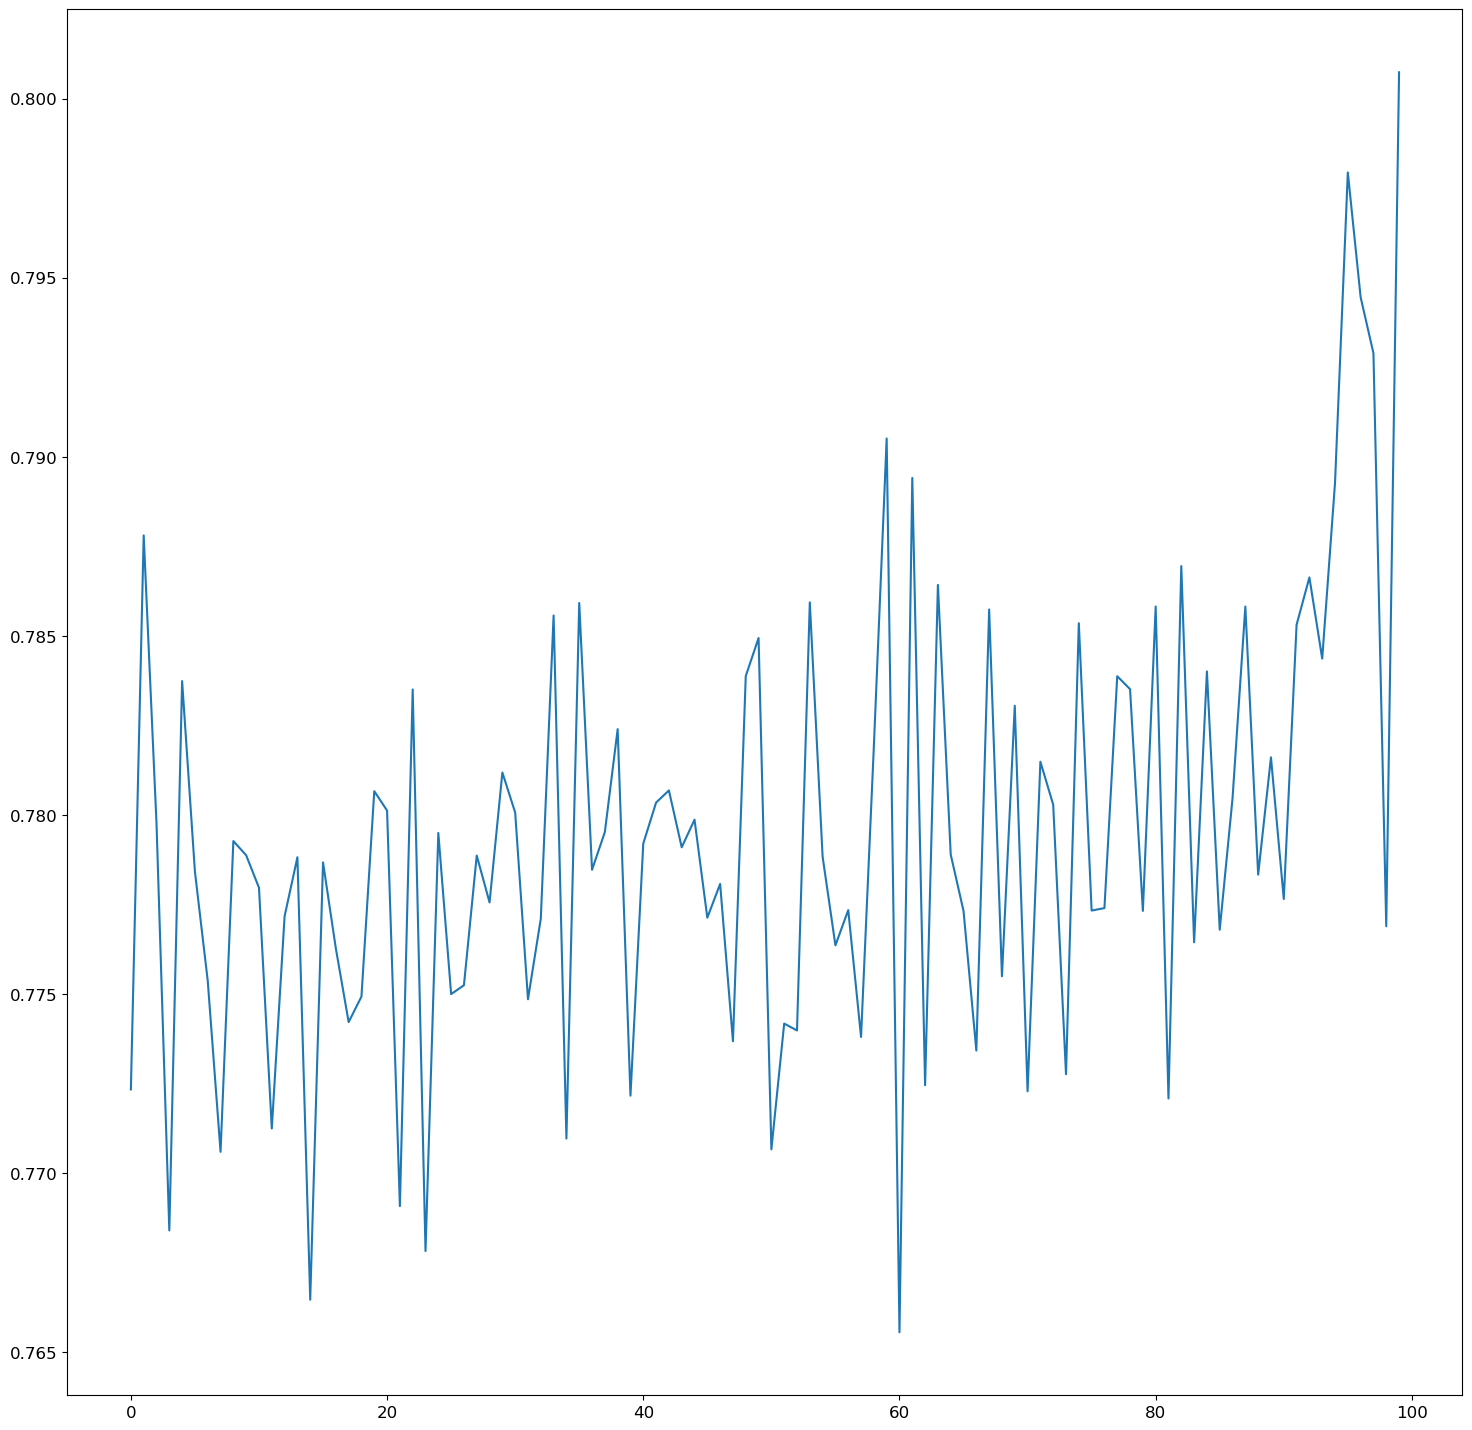

In [40]:
plt.plot(list(range(100)), em_res2)

### Predictor

In [45]:
# data_cols = [field.name for field in input_schema.fields][:-1]

data_cols = ['V' + str(i) for i in range(1,29)]
data_cols.append('Amount') 

pm = predictor_master.PredictorMaster(data_cols, task)

In [46]:
output_schema = pm.output_schema

In [47]:
pm_zeits = []
pm_ns = []
for i in range(100):
    df = spark.read.format("csv").options(header='false').schema(output_schema). \
        load("hdfs://cluster-9e14-m/user/hdfs/evaluation/pm/benchmark/case" + str(i))
    pdf = df.toPandas()
    zeit = pdf.groupby(["hostname", "hash"])["training_time"].max().sum()
    n = pdf.groupby(["hostname", "hash"])["n"].max().sum()
    
    print(" ")
    print("FILE " + str(i) )
    print("Training time: " + str(zeit) )
    if n != 284807:
        print("Observations (not 284807): " + str(n))
    pm_zeits.append(zeit)
    pm_ns.append(n)
    

 
FILE 0
Training time: 166.45218


 
FILE 1
Training time: 338.68042
Observations (not 284807): 569614


 
FILE 2
Training time: 506.97015
Observations (not 284807): 854421


 
FILE 3
Training time: 678.88086
Observations (not 284807): 1139228


 
FILE 4
Training time: 850.98706
Observations (not 284807): 1424035


 
FILE 5
Training time: 1022.1092
Observations (not 284807): 1708842


 
FILE 6
Training time: 1192.9838
Observations (not 284807): 1993649


 
FILE 7
Training time: 1363.8186
Observations (not 284807): 2278456


 
FILE 8
Training time: 1535.0505
Observations (not 284807): 2563263


 
FILE 9
Training time: 1706.821
Observations (not 284807): 2848070


 
FILE 10
Training time: 1879.9143
Observations (not 284807): 3132877


 
FILE 11
Training time: 2050.0215
Observations (not 284807): 3417684


 
FILE 12
Training time: 2221.6594
Observations (not 284807): 3702491


 
FILE 13
Training time: 2393.5789
Observations (not 284807): 3987298


 
FILE 14
Training time: 2565.16
Observations (not 284807): 4272105


 
FILE 15
Training time: 2735.5698
Observations (not 284807): 4556912


 
FILE 16
Training time: 2907.1309
Observations (not 284807): 4841719


 
FILE 17
Training time: 3076.3647
Observations (not 284807): 5126526


 
FILE 18
Training time: 3247.3708
Observations (not 284807): 5411333


 
FILE 19
Training time: 3418.7808
Observations (not 284807): 5696140


 
FILE 20
Training time: 3587.842
Observations (not 284807): 5980947


 
FILE 21
Training time: 3759.8262
Observations (not 284807): 6265754


 
FILE 22
Training time: 3932.4294
Observations (not 284807): 6550561


 
FILE 23
Training time: 4103.304
Observations (not 284807): 6835368


 
FILE 24
Training time: 4273.6724
Observations (not 284807): 7120175


 
FILE 25
Training time: 4447.2476
Observations (not 284807): 7404982


 
FILE 26
Training time: 4619.8555
Observations (not 284807): 7689789


 
FILE 27
Training time: 4789.4814
Observations (not 284807): 7974596


 
FILE 28
Training time: 4960.319
Observations (not 284807): 8259403


 
FILE 29
Training time: 5131.43
Observations (not 284807): 8544210


 
FILE 30
Training time: 5303.5796
Observations (not 284807): 8829017


 
FILE 31
Training time: 5474.1333
Observations (not 284807): 9113824


 
FILE 32
Training time: 5643.747
Observations (not 284807): 9398631


 
FILE 33
Training time: 5814.521
Observations (not 284807): 9683438


 
FILE 34
Training time: 5984.879
Observations (not 284807): 9968245


 
FILE 35
Training time: 6157.1885
Observations (not 284807): 10253052


 
FILE 36
Training time: 6328.167
Observations (not 284807): 10537859


 
FILE 37
Training time: 6498.1367
Observations (not 284807): 10822666


 
FILE 38
Training time: 6668.787
Observations (not 284807): 11107473


 
FILE 39
Training time: 6840.496
Observations (not 284807): 11392280


 
FILE 40
Training time: 7011.2754
Observations (not 284807): 11677087


 
FILE 41
Training time: 7185.169
Observations (not 284807): 11961894


 
FILE 42
Training time: 7356.586
Observations (not 284807): 12246701


 
FILE 43
Training time: 7526.79
Observations (not 284807): 12531508


 
FILE 44
Training time: 7698.265
Observations (not 284807): 12816315


 
FILE 45
Training time: 7869.2285
Observations (not 284807): 13101122


 
FILE 46
Training time: 8043.4346
Observations (not 284807): 13385929


 
FILE 47
Training time: 8213.809
Observations (not 284807): 13670736


 
FILE 48
Training time: 8383.973
Observations (not 284807): 13955543


 
FILE 49
Training time: 8556.992
Observations (not 284807): 14240350


 
FILE 50
Training time: 8728.957
Observations (not 284807): 14525157


 
FILE 51
Training time: 8901.285
Observations (not 284807): 14809964


 
FILE 52
Training time: 9072.825
Observations (not 284807): 15094771


 
FILE 53
Training time: 9245.673
Observations (not 284807): 15379578


 
FILE 54
Training time: 9416.613
Observations (not 284807): 15664385


 
FILE 55
Training time: 9589.574
Observations (not 284807): 15949192


 
FILE 56
Training time: 9762.022
Observations (not 284807): 16233999


 
FILE 57
Training time: 9932.48
Observations (not 284807): 16518806


 
FILE 58
Training time: 10103.846
Observations (not 284807): 16803613


 
FILE 59
Training time: 10275.844
Observations (not 284807): 17088420


 
FILE 60
Training time: 10446.975
Observations (not 284807): 17373227


 
FILE 61
Training time: 10620.07
Observations (not 284807): 17658034


 
FILE 62
Training time: 10790.324
Observations (not 284807): 17942841


 
FILE 63
Training time: 10965.248
Observations (not 284807): 18227648


 
FILE 64
Training time: 11135.329
Observations (not 284807): 18512455


 
FILE 65
Training time: 11308.16
Observations (not 284807): 18797262


 
FILE 66
Training time: 11479.757
Observations (not 284807): 19082069


 
FILE 67
Training time: 11653.351
Observations (not 284807): 19366876


 
FILE 68
Training time: 11823.609
Observations (not 284807): 19651683


 
FILE 69
Training time: 11994.549
Observations (not 284807): 19936490


 
FILE 70
Training time: 12166.092
Observations (not 284807): 20221297


 
FILE 71
Training time: 12338.172
Observations (not 284807): 20506104


 
FILE 72
Training time: 12509.2295
Observations (not 284807): 20790911


 
FILE 73
Training time: 12682.445
Observations (not 284807): 21075718


 
FILE 74
Training time: 12852.182
Observations (not 284807): 21360525


 
FILE 75
Training time: 13024.773
Observations (not 284807): 21645332


 
FILE 76
Training time: 13195.178
Observations (not 284807): 21930139


 
FILE 77
Training time: 13364.754
Observations (not 284807): 22214946


 
FILE 78
Training time: 13535.947
Observations (not 284807): 22499753


 
FILE 79
Training time: 13707.617
Observations (not 284807): 22784560


 
FILE 80
Training time: 13878.335
Observations (not 284807): 23069367


 
FILE 81
Training time: 14050.211
Observations (not 284807): 23354174


 
FILE 82
Training time: 14221.783
Observations (not 284807): 23638981


 
FILE 83
Training time: 14393.133
Observations (not 284807): 23923788


 
FILE 84
Training time: 14564.282
Observations (not 284807): 24208595


 
FILE 85
Training time: 14734.596
Observations (not 284807): 24493402


 
FILE 86
Training time: 14905.643
Observations (not 284807): 24778209


 
FILE 87
Training time: 15078.469
Observations (not 284807): 25063016


 
FILE 88
Training time: 15249.381
Observations (not 284807): 25347823


 
FILE 89
Training time: 15420.582
Observations (not 284807): 25632630


 
FILE 90
Training time: 15591.61
Observations (not 284807): 25917437


 
FILE 91
Training time: 15762.426
Observations (not 284807): 26202244


 
FILE 92
Training time: 15933.424
Observations (not 284807): 26487051


 
FILE 93
Training time: 16106.545
Observations (not 284807): 26771858


 
FILE 94
Training time: 16276.191
Observations (not 284807): 27056665


 
FILE 95
Training time: 16448.7
Observations (not 284807): 27341472


 
FILE 96
Training time: 16619.477
Observations (not 284807): 27626279


 
FILE 97
Training time: 16790.027
Observations (not 284807): 27911086


 
FILE 98
Training time: 16963.902
Observations (not 284807): 28195893


 
FILE 99
Training time: 17133.617
Observations (not 284807): 28480700


In [55]:
pm_res = np.array(pm_zeits) / np.array(pm_ns) * 1000

In [51]:
pm_zeits2 = []
pm_ns2 = []
for i in range(99):
    pm_zeits2.append(pm_zeits[100-i-1] - pm_zeits[100-i-2])
    pm_ns2.append(pm_ns[100-i-1] - pm_ns[100-i-2])

pm_ns2.append(pm_ns[0])   
pm_zeits2.append(pm_zeits[0])

In [54]:
pm_res2 = np.array(pm_zeits2) / np.array(pm_ns2) * 1000
pm_res2

array([0.59589422, 0.61050115, 0.59882932, 0.59962481, 0.60570075,
       0.5956542 , 0.60785407, 0.60039973, 0.59975854, 0.60050603,
       0.60111294, 0.60009799, 0.60681855, 0.60057118, 0.5979961 ,
       0.60093121, 0.60163412, 0.6024159 , 0.60348228, 0.59941565,
       0.60275879, 0.6010855 , 0.59540732, 0.59831499, 0.60599563,
       0.59596965, 0.60818667, 0.60060889, 0.60419891, 0.60231304,
       0.600194  , 0.59780409, 0.60951364, 0.60250162, 0.6068357 ,
       0.59718004, 0.61418374, 0.59778694, 0.60776492, 0.60086606,
       0.60391088, 0.60168898, 0.59850358, 0.60549159, 0.60729174,
       0.60019743, 0.60689399, 0.60230275, 0.60506984, 0.6037943 ,
       0.60749747, 0.59747149, 0.59820869, 0.61166353, 0.60027801,
       0.60207473, 0.59761207, 0.60187071, 0.61056629, 0.59963167,
       0.60289594, 0.59917906, 0.59678915, 0.60033116, 0.60500469,
       0.59815212, 0.59961281, 0.59553933, 0.5988396 , 0.60444236,
       0.60079748, 0.59983569, 0.59558219, 0.6060522 , 0.60944

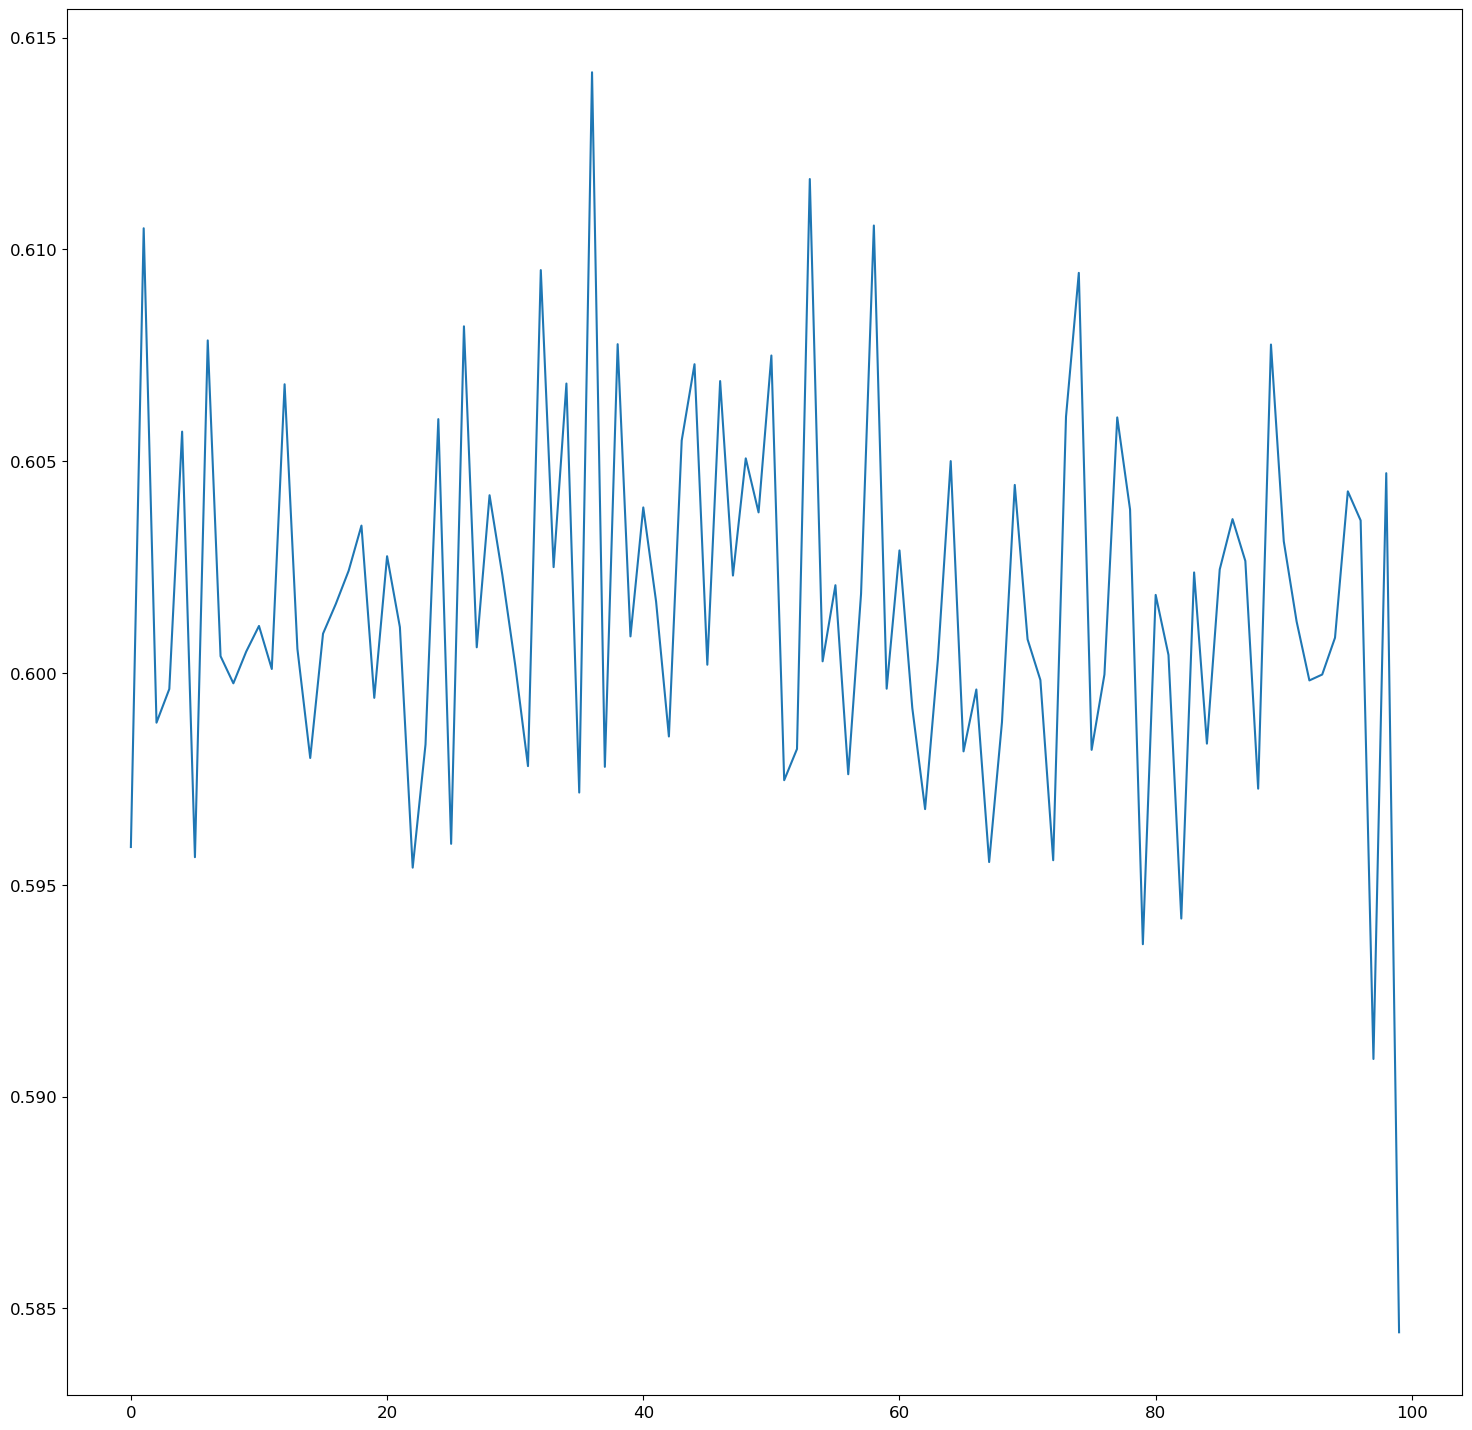

In [53]:
plt.plot(list(range(100)), pm_res2)

In [58]:
label1 = ["StreamMiner" for i in range(100)]
label2 = ["Evaluator" for i in range(100)]
label3 = ["Predictor" for i in range(100)]

In [64]:

import pandas as pd


df1 = pd.DataFrame(sm_res, label1).reset_index()
df2 = pd.DataFrame(em_res2, label2).reset_index()
df3 = pd.DataFrame(pm_res2, label3).reset_index()

In [105]:
data = df1.append(df2).append(df3)

/tmp/ipykernel_485913/446825745.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df1.append(df2).append(df3)


In [106]:
data.columns = ["Component", "Time_ms"]

In [84]:
data

,Component,Time_ms
0,StreamMiner,2.853286
1,StreamMiner,2.948015
2,StreamMiner,2.785323
3,StreamMiner,2.826965
4,StreamMiner,2.924216
...,...,...
95,Predictor,0.604291
96,Predictor,0.603604
97,Predictor,0.590890
98,Predictor,0.604719


In [76]:
import seaborn as sns

<AxesSubplot:xlabel='Component', ylabel='Time_ms'>

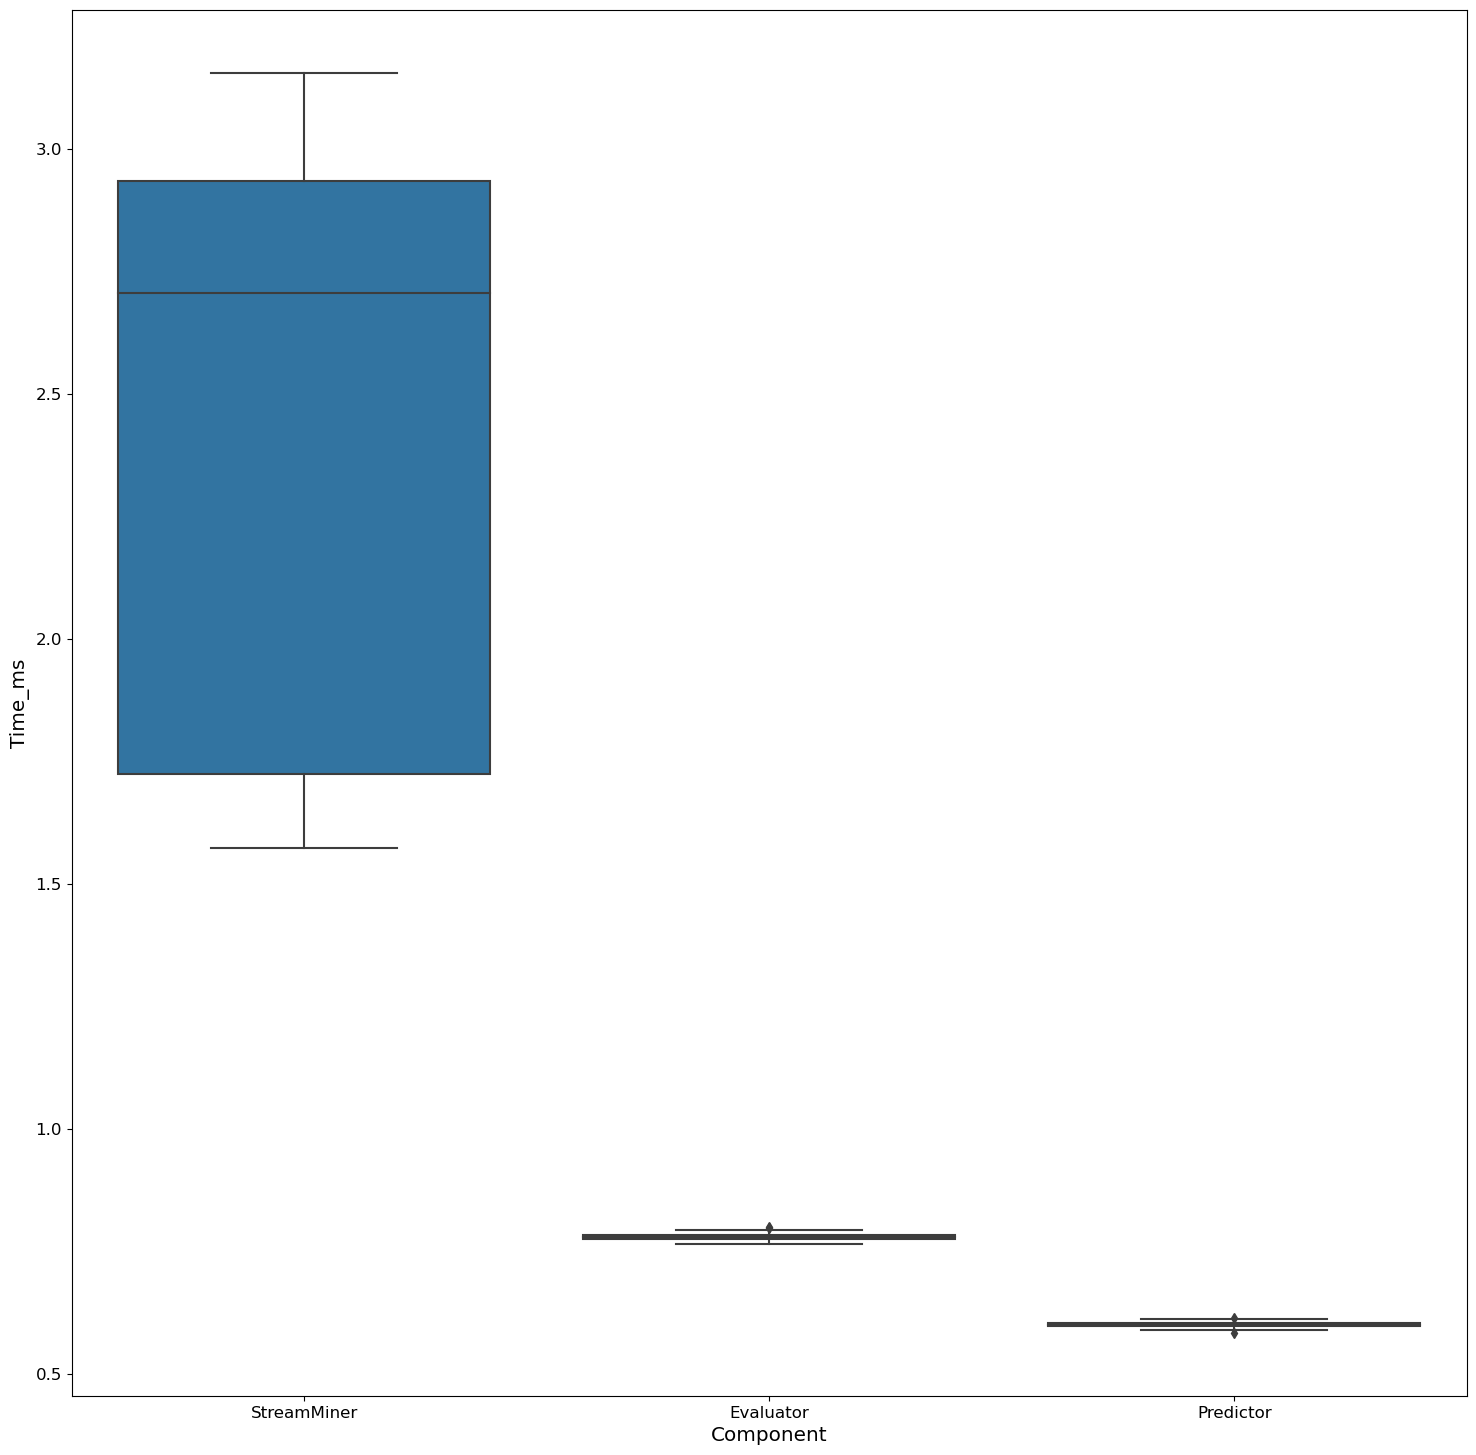

In [85]:
sns.boxplot(data, x = "Component", y = "Time_ms")

In [91]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
          'figure.figsize': (18, 18),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)


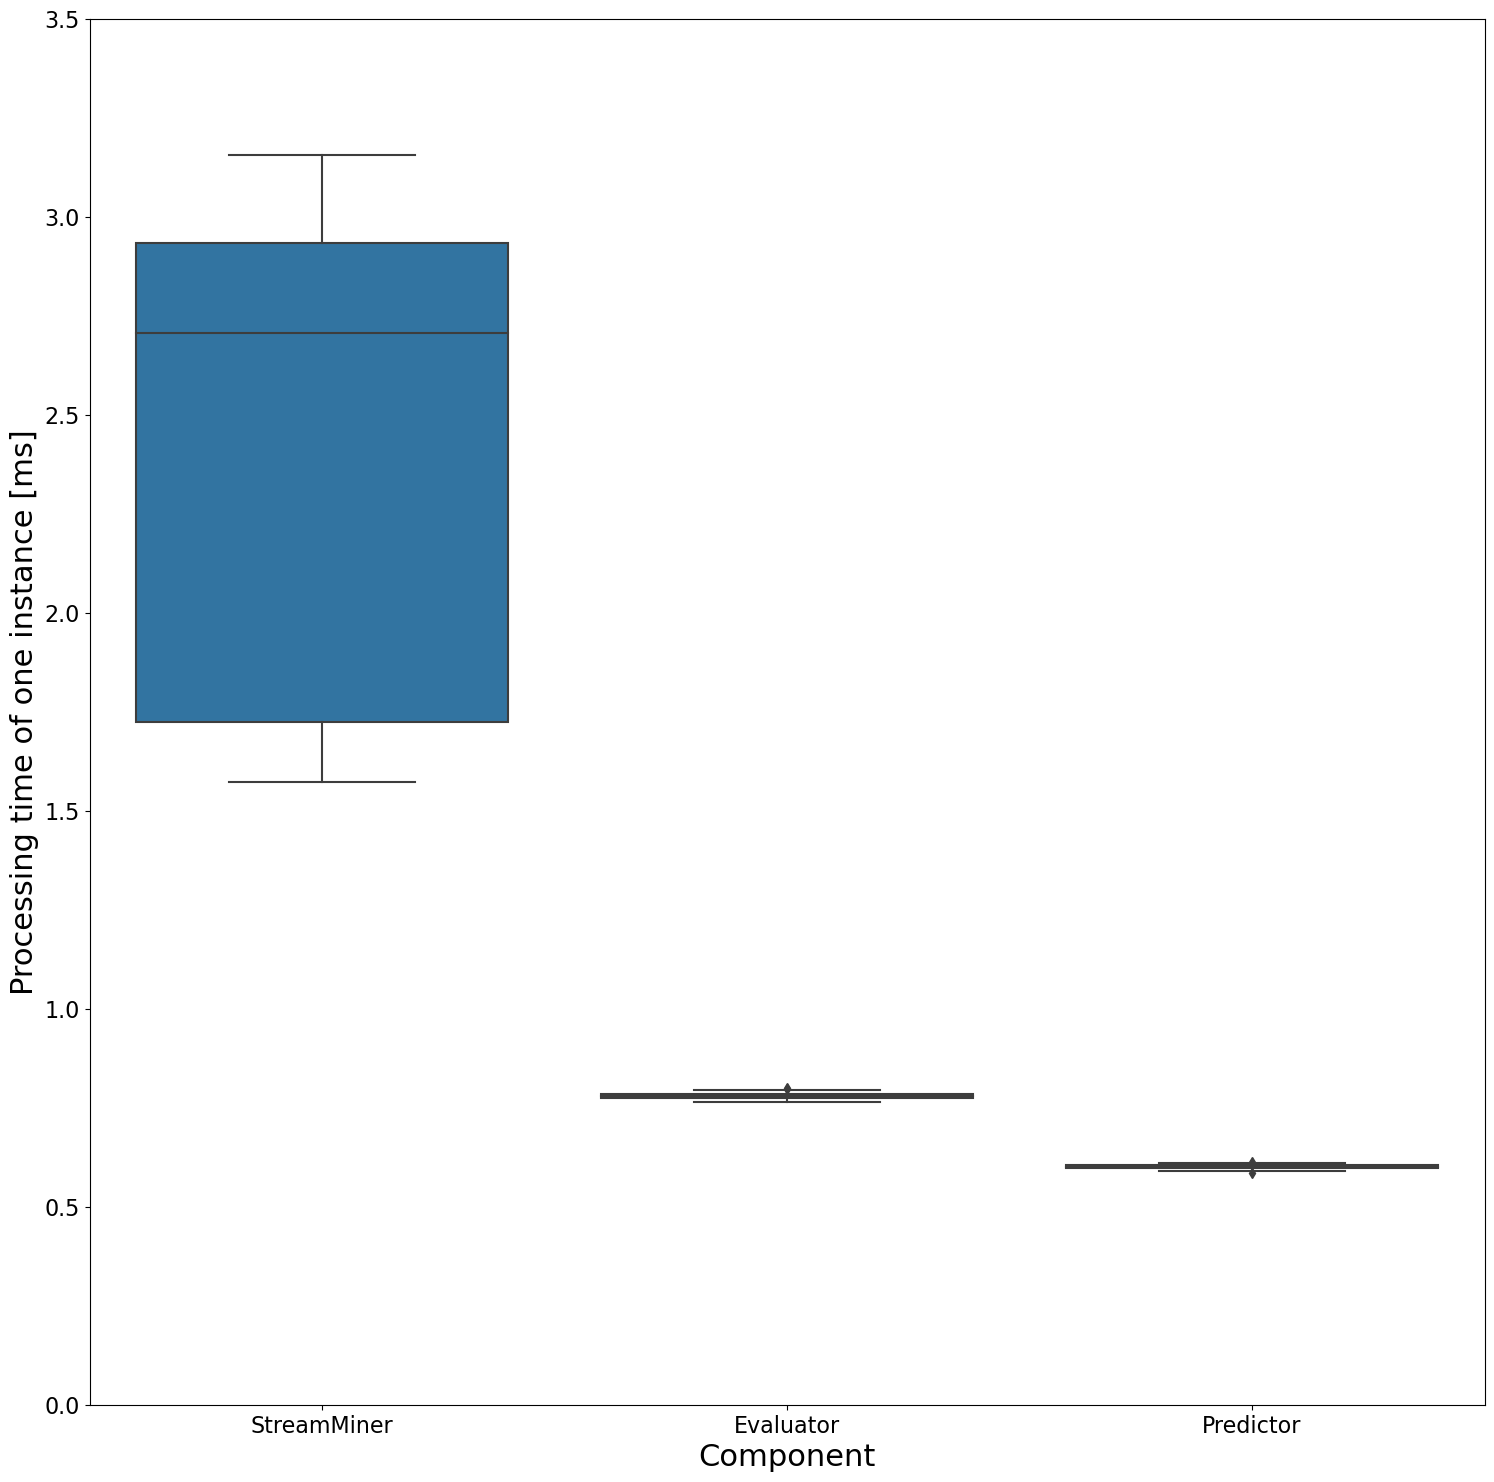

In [97]:
fig, ax = plt.subplots()
sns.boxplot(data, x = "Component", y = "Time_ms")
ax.set_ylim(0, 3.5)
ax.xaxis.label.set_size(22)
ax.yaxis.label.set_size(22)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Processing time of one instance [ms]")
plt.show()

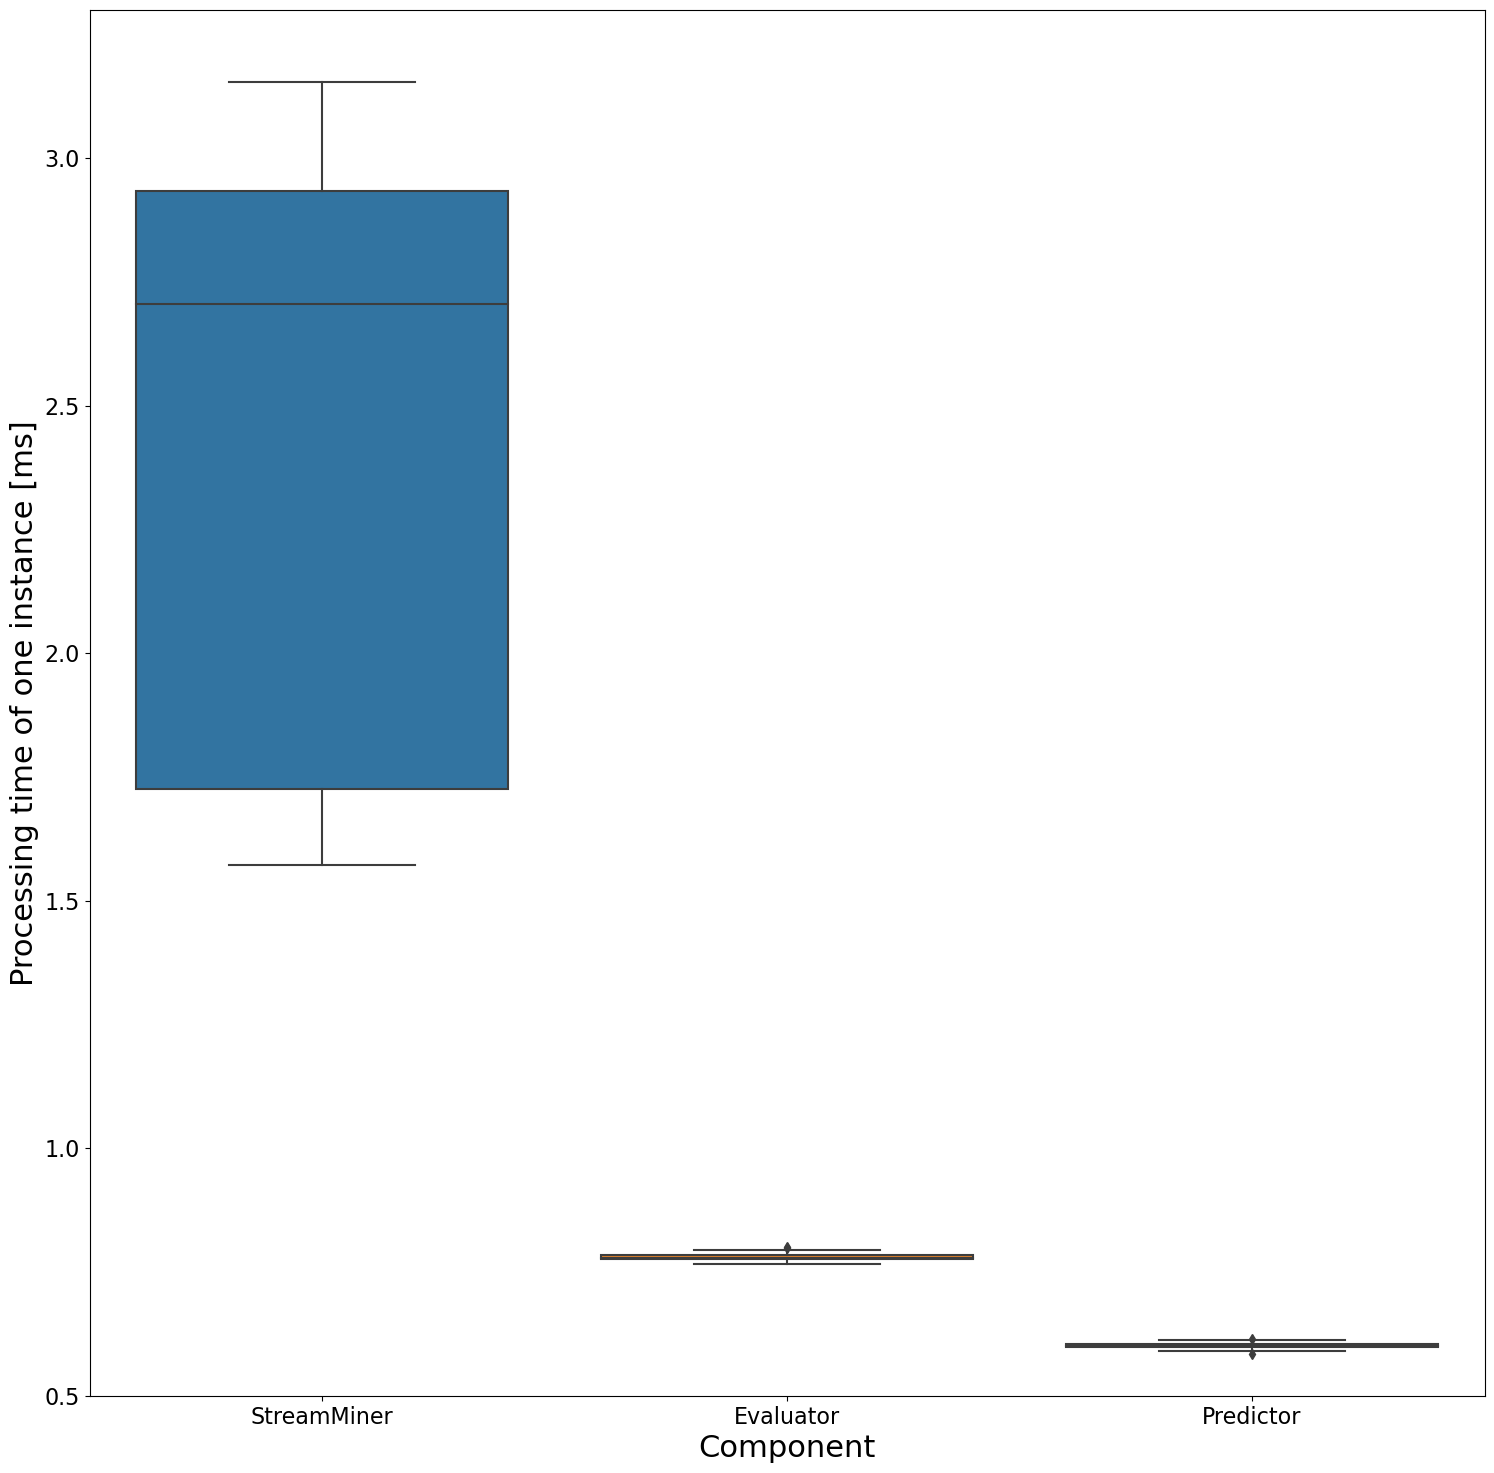

In [107]:
fig, ax = plt.subplots()
sns.boxplot(data, x = "Component", y = "Time_ms")
ax.set_ylim(0.5, 3.3)
ax.xaxis.label.set_size(22)
ax.yaxis.label.set_size(22)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Processing time of one instance [ms]")
plt.show()

In [98]:
data = df2.append(df3)
data.columns = ["Component", "Time_ms"]

/tmp/ipykernel_485913/957431048.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df2.append(df3)


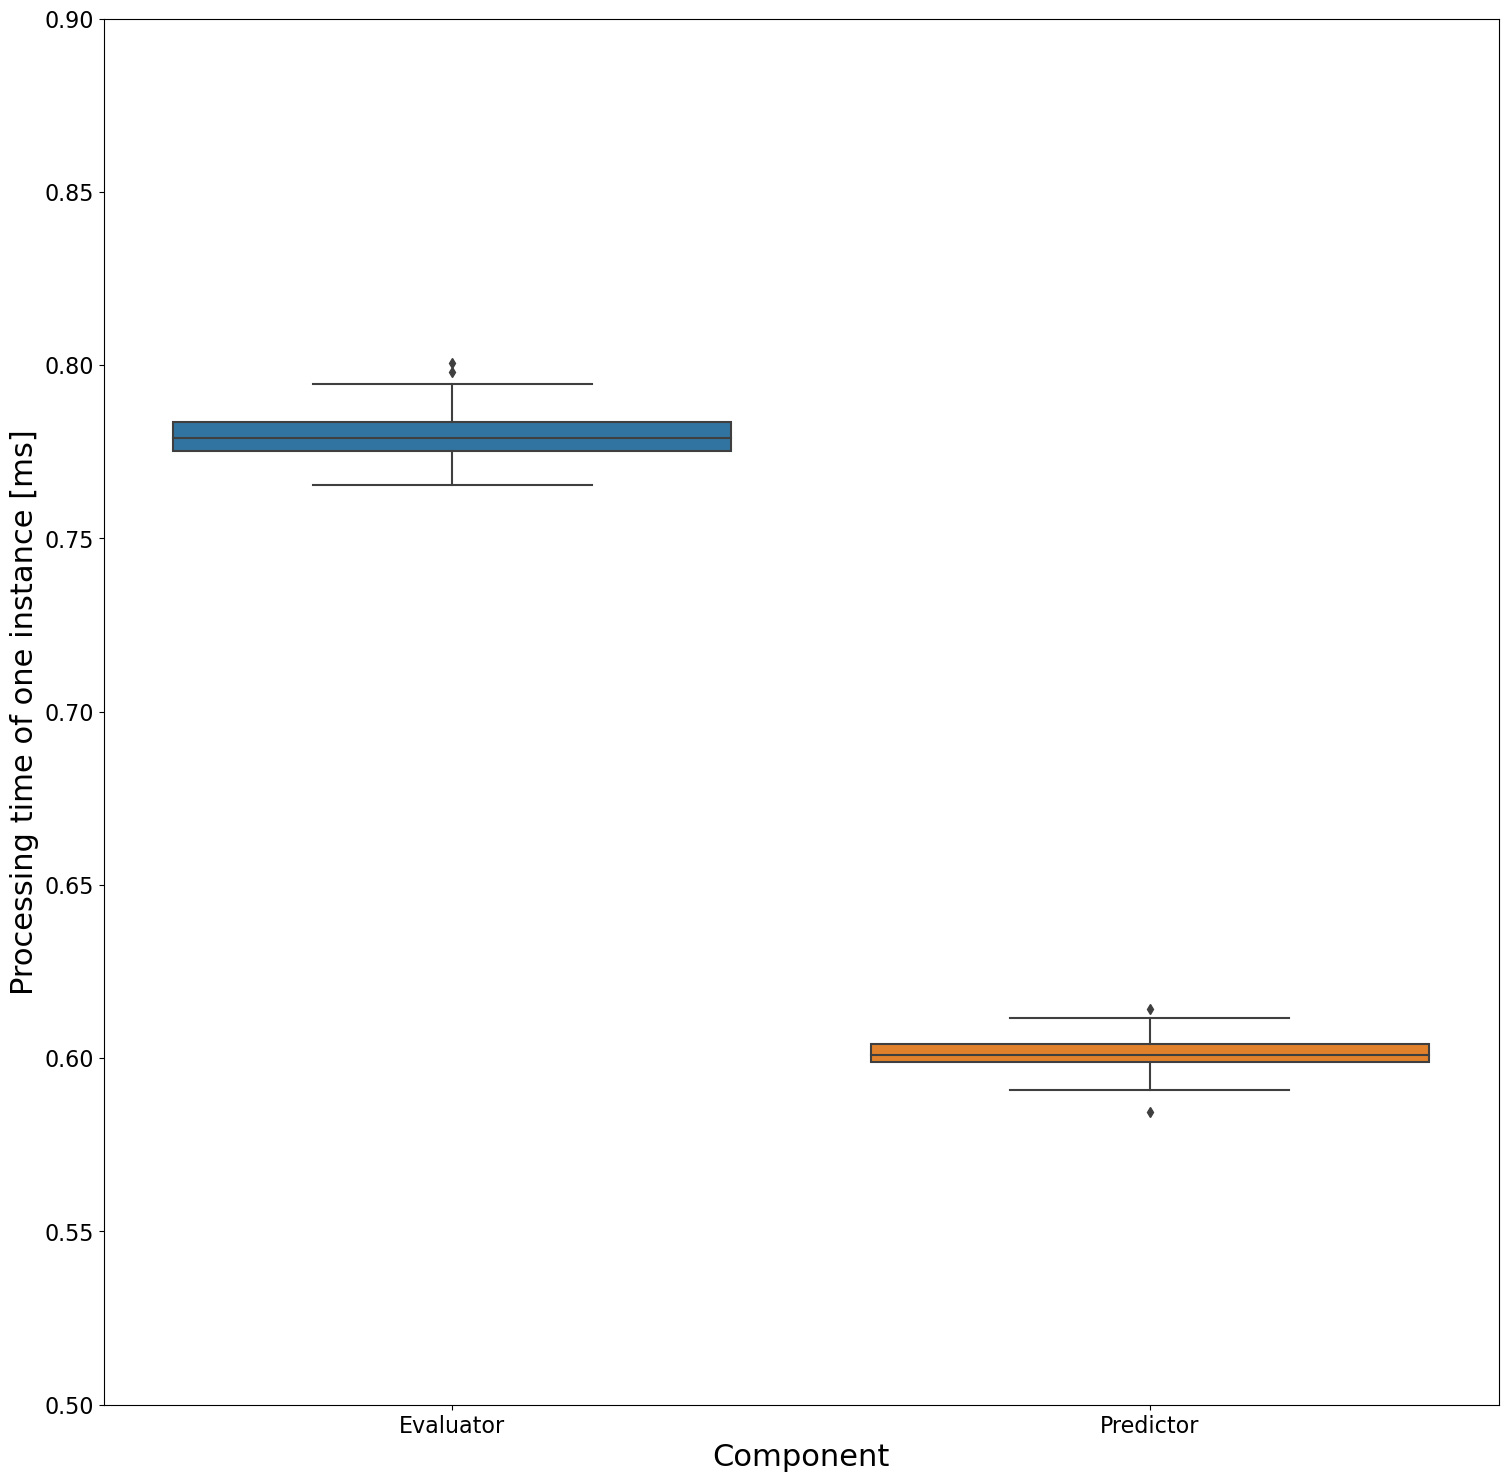

In [102]:
fig, ax = plt.subplots()
sns.boxplot(data, x = "Component", y = "Time_ms")
ax.set_ylim(0.5, 0.9)
ax.xaxis.label.set_size(22)
ax.yaxis.label.set_size(22)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Processing time of one instance [ms]")
plt.show()

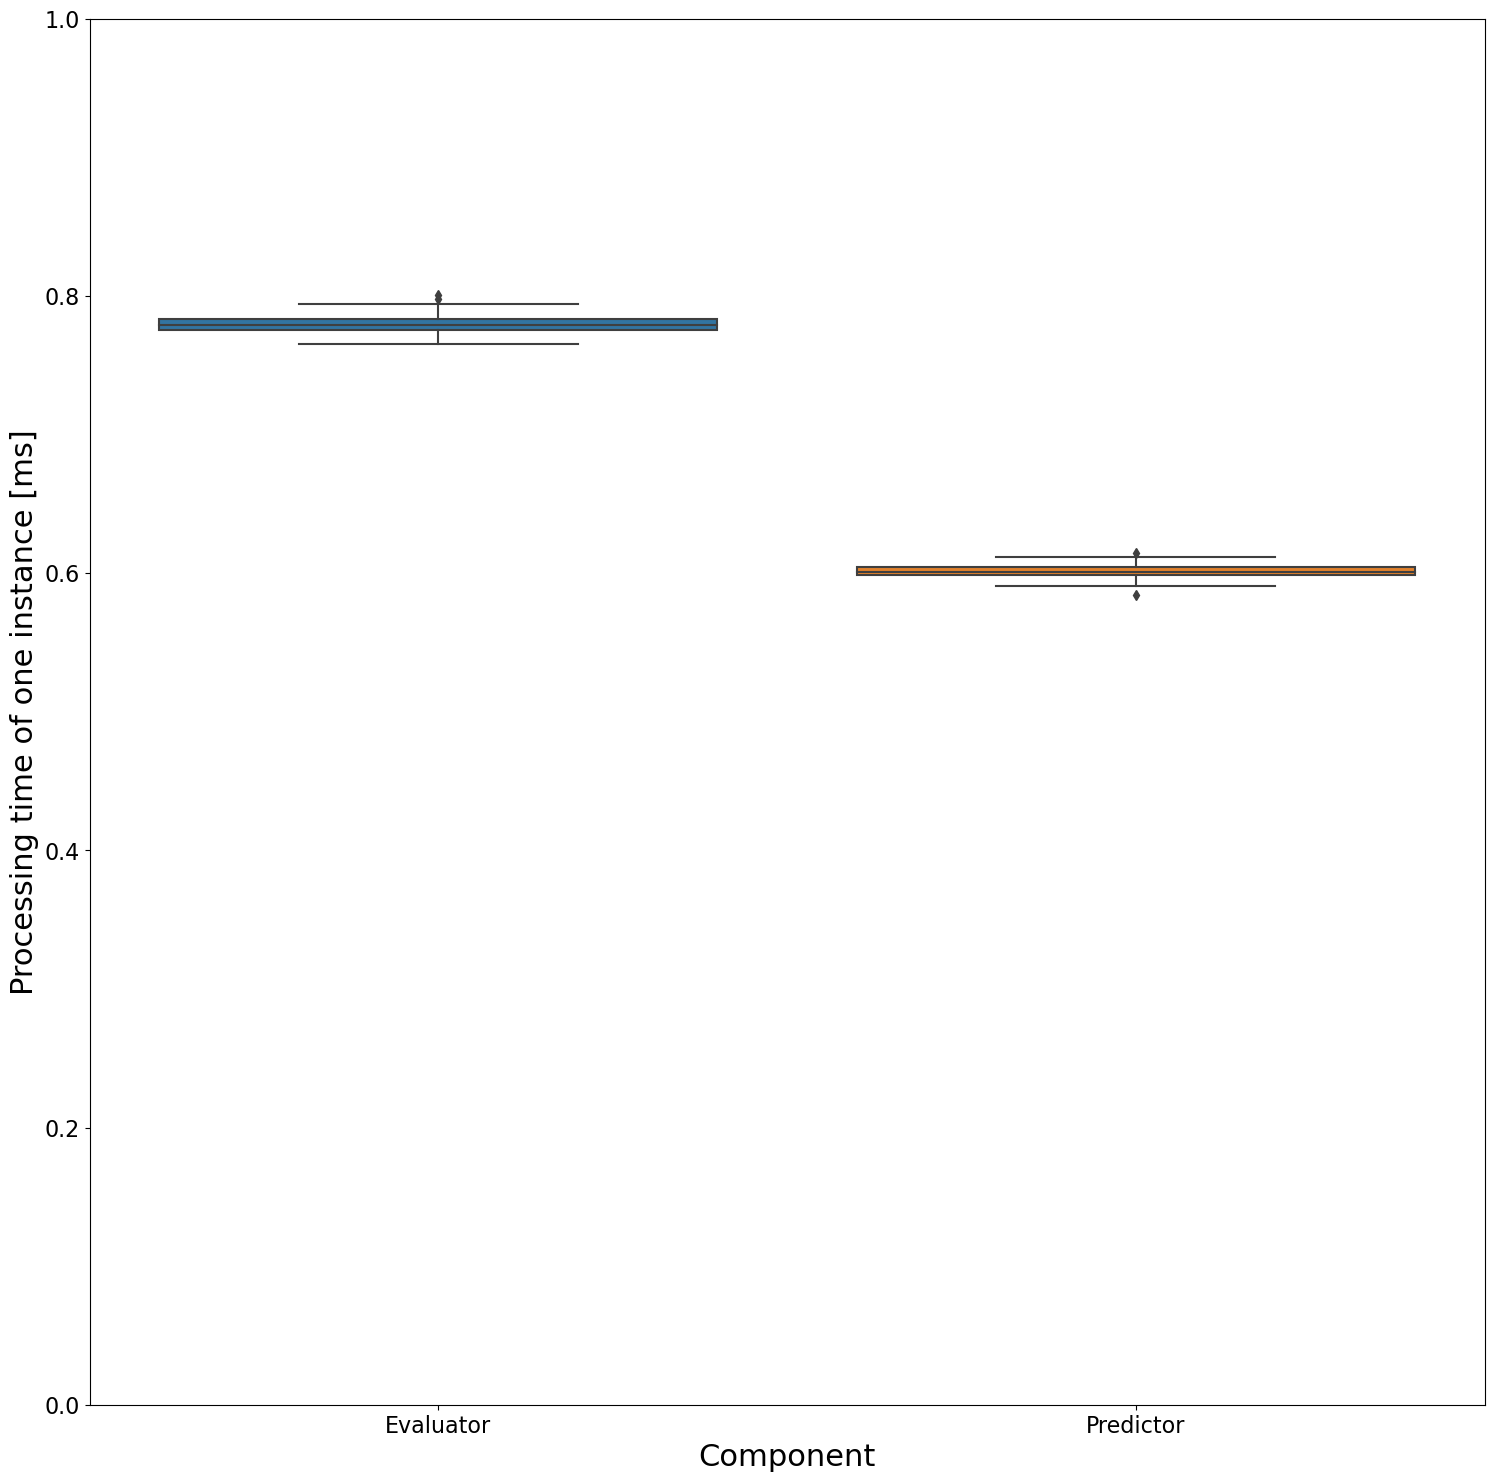

In [103]:
fig, ax = plt.subplots()
sns.boxplot(data, x = "Component", y = "Time_ms")
ax.set_ylim(0, 1)
ax.xaxis.label.set_size(22)
ax.yaxis.label.set_size(22)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Processing time of one instance [ms]")
plt.show()

### quick true labels check

In [11]:
init = InitializeA()
spark, input_schema, sc, sdf = init.spark, init.input_schema, init.sc, init.sdf

23/06/23 23:14:16 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
23/06/23 23:14:16 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/worker/evaluator.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/23 23:14:16 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/shared/evaluator_handler.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/23 23:14:16 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/worker/drift_detector.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/23 23:14:16 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/shared/drift_detector_handler.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/23 23:14:16 WARN SparkContext: The path /home/patryk_patrykwrona

In [3]:
sdf

DataFrame[V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, Class: double]

In [4]:
pdf = sdf.toPandas()

AnalysisException: Queries with streaming sources must be executed with writeStream.start();
FileSource[hdfs://cluster-9e14-m/user/hdfs/stream/hyperplane]

In [6]:
df = spark.read.format("csv").options(header='false').schema(input_schema). \
        load("hdfs://cluster-9e14-m/user/hdfs/stream/hyperplane")

In [7]:
pdf = df.toPandas()

In [8]:
pdf.head()

,V1,V2,V3,V4,V5,V6,Class
0,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,NaN
1,0.774367,0.934871,0.186875,0.229126,0.647671,0.270270,0.0
2,0.249029,0.090061,0.619018,0.780303,0.050131,0.474015,1.0
3,0.739116,0.306125,0.699495,0.400133,0.375811,0.280364,0.0
4,0.245736,0.763120,0.902215,0.990406,0.964726,0.437921,1.0


In [9]:
np.unique(pdf.iloc[1:, :].Class, return_counts=True)

(array([ 0.,  1., nan]), array([100056,  99944,     79]))

In [10]:
99944/2000

49.972

In [12]:
df = spark.read.format("csv").options(header='false').schema(input_schema). \
        load("hdfs://cluster-9e14-m/user/hdfs/stream/agrawal")

In [13]:
pdf = df.toPandas()

In [14]:
np.unique(pdf.iloc[1:, :].Class, return_counts=True)

(array([ 0.,  1., nan]), array([100000, 100000,     79]))